Exercises:
E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [44]:
import torch
import torch.nn.functional as F

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
# create the training set
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] +   list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        print(ch1,ch2,ch3)
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append((ix1, ix2))
        ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e m
e m m
m m a
m a .


In [5]:
xs,ys

(tensor([[ 0,  5],
         [ 5, 13],
         [13, 13],
         [13,  1]]),
 tensor([13, 13,  1,  0]))

In [6]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
print(xenc.shape)
xenc = xenc.reshape((xenc.shape[0],54))
xenc

torch.Size([4, 2, 27])


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

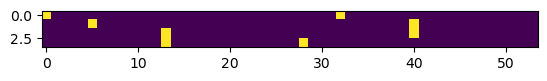

In [7]:
from matplotlib import pyplot as plt
plt.imshow(xenc)

In [ ]:
# Instead of using one neuron, lets use 27 neurons to have a more powerful model
# randomly initialize weights of 27 neurons. Each neuron recieves 54 inputs.
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g, requires_grad=True)
# for example, below tells us the firing rate of the 13th neuron on the 3rd input.
(xenc@W).shape, (xenc@W)[3,13]

In [ ]:
# This is the output of the neural network. We need to somwhow convert these numbers to represent probabilities.
# Probaive numbers wil become less than 1 and positive numbers will be greater than 1.
logits = xenc@W #log-counts
counts = logits.exp() # equivalent to the N matrix above, we can interpret these as counts.
probs = counts/counts.sum(1, keepdims=True)

In [ ]:
probs.shape

In [ ]:
#EVERYTHING TOGETHER

In [45]:
# create the training set
xs, ys = [], []
for w in words:
    chs = ['.'] +   list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append((ix1, ix2))
        ys.append(ix3)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xenc = F.one_hot(xs, num_classes=27).float()
xenc = xenc.reshape((xenc.shape[0],54))
xenc.shape

torch.Size([196113, 54])

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(xs, ys, test_size=0.1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1)

In [47]:
len(xs), len(X_train), len(X_valid), len(X_test), X_train.shape

(196113, 158850, 17651, 19612, torch.Size([158850, 2]))

In [48]:
#initialize the network
g = torch.Generator().manual_seed(2147)
W = torch.randn((54,27), generator=g, requires_grad = True)
num = X_train.shape[0]
print("number of examples:", num)

number of examples: 158850


In [51]:
# gradient descent
for k in range(10):
    # forward pass
    xenc = F.one_hot(X_train, num_classes=27).float()
    xenc = xenc.reshape((xenc.shape[0],54))
    logits = xenc @ W #predict log counts
    #print(logits.shape)
    counts = logits.exp() # counts, equivalent to N matrix.
    probs = counts/ counts.sum(1, keepdims=True) # pribability for next character
    #print(ys.shape)
    #print(probs.shape)
    loss = -probs[torch.arange(num), Y_train].log().mean()
    cross_entropy_loss = F.cross_entropy(logits, Y_train)
    print(f"loss {loss}")
    print(f"cross entropy loss {cross_entropy_loss}")
    #assert torch.equal(loss, cross_entropy_loss)
    if k%50==0:
        print(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -50*W.grad

loss 4.112748622894287
cross entropy loss 4.112748146057129
4.112748622894287
loss 3.368908166885376
cross entropy loss 3.368908166885376
loss 3.062563419342041
cross entropy loss 3.062563180923462
loss 2.8838279247283936
cross entropy loss 2.8838281631469727
loss 2.7725799083709717
cross entropy loss 2.7725796699523926
loss 2.6940906047821045
cross entropy loss 2.6940908432006836
loss 2.636172294616699
cross entropy loss 2.6361725330352783
loss 2.591249704360962
cross entropy loss 2.591249704360962
loss 2.5560102462768555
cross entropy loss 2.5560100078582764
loss 2.527355432510376
cross entropy loss 2.527355194091797


Lets put it all inside a single function to initialize and train the network. This way, we can try different parameters for the regularization strength. Lets also create a separate function for doing a forward pass in a trained network to evaluate the validation and test losses.

In [37]:
def train_network(num_iterations, reg_strength):
    # initialize the network
    g = torch.Generator().manual_seed(2147)
    W = torch.randn((54,27), generator=g, requires_grad = True)
    num = X_train.shape[0]
    # gradient descent
    for k in range(num_iterations):
        # forward pass
        xenc = F.one_hot(X_train, num_classes=27).float()
        xenc = xenc.reshape((xenc.shape[0],54))
        #print(xenc.shape)
        logits = xenc @ W #predict log counts
        #print(logits.shape)
        counts = logits.exp() # counts, equivalent to N matrix.
        probs = counts/ counts.sum(1, keepdims=True) # pribability for next character
        #print(ys.shape)
        #print(probs.shape)
        loss = -probs[torch.arange(num), Y_train].log().mean()+reg_strength*(W**2).mean()
        if k%50==0:
            print("loss", loss.item())
            print("-----")
            print("weights mean", (W**2).mean())
    
        # backward pass
        W.grad = None
        loss.backward()
    
        # update
        W.data += -50*W.grad
        if k%50==0:
            print("*******")
            print("gradients mean", (W.grad).mean())
    return W

In [13]:
def forward_pass(X,Y,W):
    xenc = F.one_hot(X, num_classes=27).float()
    num_samples = len(X)
    xenc = xenc.reshape((xenc.shape[0],54))
    #print(xenc.shape)
    logits = xenc @ W #predict log counts
    #print(logits.shape)
    counts = logits.exp() # counts, equivalent to N matrix.
    probs = counts/ counts.sum(1, keepdims=True) # pribability for next character
    #print(ys.shape)
    #print(probs.shape)
    loss = -probs[torch.arange(num_samples), Y].log().mean()
    return loss

In [39]:
W = train_network(1000, 0.01)

loss 4.1226019859313965
-----
weights mean tensor(1.0290, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.8299e-07)
loss 2.299837350845337
-----
weights mean tensor(0.8019, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.7008e-07)
loss 2.2706480026245117
-----
weights mean tensor(0.8855, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.5758e-07)
loss 2.261986494064331
-----
weights mean tensor(0.9524, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.4554e-07)
loss 2.2580580711364746
-----
weights mean tensor(1.0032, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.3388e-07)
loss 2.255894899368286
-----
weights mean tensor(1.0430, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.2264e-07)
loss 2.254575729370117
-----
weights mean tensor(1.0748, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.1174e-07)
loss 2.2537178993225098
-----
weights mean tensor(1.1005, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.0123e-

In [15]:
#Evaluate validation and test losses
validation_loss = forward_pass(X_valid, Y_valid, W)
test_loss = forward_pass(X_test, Y_test, W)

print(f"validation loss {validation_loss}")
print(f"test loss {test_loss}")

validation loss 2.2555809020996094
test loss 2.2420644760131836


In [16]:
W1 = train_network(1000, 0.1)

4.215212345123291
2.349971294403076
2.325970411300659
2.3205535411834717
2.318787097930908
2.318115711212158
2.3178393840789795
2.3177201747894287
2.3176662921905518
2.317641258239746
2.317629814147949
2.31762433052063
2.3176214694976807
2.317620038986206
2.3176193237304688
2.3176190853118896
2.3176190853118896
2.3176188468933105
2.3176188468933105
2.3176188468933105


In [17]:
#Evaluate validation and test losses
validation_loss = forward_pass(X_valid, Y_valid, W1)
test_loss = forward_pass(X_test, Y_test, W1)

print(f"validation loss {validation_loss}")
print(f"test loss {test_loss}")

validation loss 2.2783801555633545
test loss 2.2667903900146484


In [38]:
W2 = train_network(1000, 1)

loss 5.1413164138793945
-----
weights mean tensor(1.0290, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.8299e-05)
loss 2.5447347164154053
-----
weights mean tensor(0.1520, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-1.0972e-06)
loss 2.544528007507324
-----
weights mean tensor(0.1521, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.1444e-08)
loss 2.544528007507324
-----
weights mean tensor(0.1521, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-8.9766e-10)
loss 2.544528007507324
-----
weights mean tensor(0.1521, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-2.5763e-11)
loss 2.544528007507324
-----
weights mean tensor(0.1521, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-6.1765e-12)
loss 2.544528007507324
-----
weights mean tensor(0.1521, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-6.6431e-12)
loss 2.544528007507324
-----
weights mean tensor(0.1521, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-6.1711e-12

In [19]:
#Evaluate validation and test losses
validation_loss = forward_pass(X_valid, Y_valid, W2)
test_loss = forward_pass(X_test, Y_test, W2)

print(f"validation loss {validation_loss}")
print(f"test loss {test_loss}")

validation loss 2.4009649753570557
test loss 2.394542694091797


In [28]:
W3 = train_network(1000, 100)

107.01277160644531
-----
tensor(1.0290, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)
nan
-----
tensor(nan, grad_fn=<MeanBackward0>)


In [41]:
W.mean(), W1.mean(), W2.mean(), W3.mean(), W4.mean()

(tensor(-0.0141, grad_fn=<MeanBackward0>),
 tensor(-2.8622e-05, grad_fn=<MeanBackward0>),
 tensor(-8.0127e-09, grad_fn=<MeanBackward0>),
 tensor(nan, grad_fn=<MeanBackward0>),
 tensor(-0.0261, grad_fn=<MeanBackward0>))

In [40]:
W4 = train_network(1000, 0.001)

loss 4.113340854644775
-----
weights mean tensor(1.0290, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.8295e-08)
loss 2.292961597442627
-----
weights mean tensor(0.8336, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.8170e-08)
loss 2.262380599975586
-----
weights mean tensor(0.9432, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.8034e-08)
loss 2.252805471420288
-----
weights mean tensor(1.0355, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.7895e-08)
loss 2.2482104301452637
-----
weights mean tensor(1.1112, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.7774e-08)
loss 2.245532751083374
-----
weights mean tensor(1.1751, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.7639e-08)
loss 2.2438058853149414
-----
weights mean tensor(1.2303, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.7522e-08)
loss 2.2426209449768066
-----
weights mean tensor(1.2788, grad_fn=<MeanBackward0>)
*******
gradients mean tensor(-3.7398e-0

In [21]:
#Evaluate validation and test losses
validation_loss = forward_pass(X_valid, Y_valid, W3)
test_loss = forward_pass(X_test, Y_test, W3)

print(f"validation loss {validation_loss}")
print(f"test loss {test_loss}")

validation loss nan
test loss nan


In [42]:
#Evaluate validation and test losses
validation_loss = forward_pass(X_valid, Y_valid, W4)
test_loss = forward_pass(X_test, Y_test, W4)

print(f"validation loss {validation_loss}")
print(f"test loss {test_loss}")

validation loss 2.2540059089660645
test loss 2.240072011947632


In [ ]:
import random
random.randint(0,27)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
ix0 = 0
ix1=random.randint(0,26)
for i in range(10):
    out = []
    while True:
        #p = N[ix].float()
        #p = p/p.sum()
        #p = P[ix]
        xenc = F.one_hot(torch.tensor((ix0,ix1)), num_classes=27).float() # input to neural network: one hot encoded
        print(xenc.shape)
        xenc = xenc.reshape((1,54))
        logits = xenc @ W #predict log counts
        counts = logits.exp() # counts, equivalent to N matrix.
        probs = counts/ counts.sum(1, keepdims=True) # pribability for next character
        ix0=ix1
        ix1 = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix1])
        if ix1 == 0: 
            break
    print(''.join(out))